In [1]:
!pip install beautifulsoup4
!pip install requests_cache

In [2]:
import requests
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import requests_cache
import lxml.html as lxl
import re

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import sklearn.metrics as metrics

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,AgglomerativeClustering
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset/true_car_listings.csv').sample(frac=1).reset_index(drop=True)
df.head(10)

,Price,Year,Mileage,City,State,Vin,Make,Model
0,24482,2014,37055,Matteson,IL,1GNKRJKDXEJ165034,Chevrolet,TraverseLTZ
1,26189,2017,25134,Grapevine,TX,1GAZGMFGXH1193321,Chevrolet,Express
2,13208,2016,15682,ORLANDO,FL,JA32U2FU6GU000783,Mitsubishi,LancerES
3,7950,2006,96014,Midlothian,VA,1ZVFT80N065200235,Ford,Mustang2dr
4,17900,2014,41081,Little Rock,AR,4T1BK1FK1EU027365,Toyota,CamryXLE
5,14888,2011,98480,Milwaukie,OR,2T3DK4DVXBW053540,Toyota,RAV44WD
6,9566,2008,85645,Amherst,NY,2C3KA33G88H284344,Chrysler,3004dr
7,19995,2010,118042,Griffin,GA,1GYUKAEF6AR110766,Cadillac,EscaladeBase
8,25580,2016,31307,Killeen,TX,WBA8E9C58GK647189,BMW,3
9,20884,2009,101570,Helena,MT,2GCEK333791133489,Chevrolet,Silverado


In [7]:
df = df[:5000]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Price    5000 non-null   int64 
 1   Year     5000 non-null   int64 
 2   Mileage  5000 non-null   int64 
 3   City     5000 non-null   object
 4   State    5000 non-null   object
 5   Vin      5000 non-null   object
 6   Make     5000 non-null   object
 7   Model    5000 non-null   object
dtypes: int64(3), object(5)
memory usage: 312.6+ KB


In [9]:
df.shape

(5000, 8)

In [10]:
df.isnull().sum()

Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

# **Data Preprocessing**

In [11]:
df["Current_Year"] = 2021

In [12]:
df["Age"] = df["Current_Year"] - df["Year"]
df["Original_Price"] = df["Price"]/ ((1 - (0.45)) ** 3)
df["Depreciation"] = df["Original_Price"] - df["Price"]
df["Percent_Loss"] = df["Price"] / df["Original_Price"]
#df["Good_Buy"] = 1 if np.where(df["Percent_Loss"] < 0.6) else 0

In [13]:
df.head(10)

,Price,Year,Mileage,City,State,Vin,Make,Model,Current_Year,Age,Original_Price,Depreciation,Percent_Loss
0,24482,2014,37055,Matteson,IL,1GNKRJKDXEJ165034,Chevrolet,TraverseLTZ,2021,7,147149.511645,122667.511645,0.166375
1,26189,2017,25134,Grapevine,TX,1GAZGMFGXH1193321,Chevrolet,Express,2021,4,157409.466566,131220.466566,0.166375
2,13208,2016,15682,ORLANDO,FL,JA32U2FU6GU000783,Mitsubishi,LancerES,2021,5,79386.927122,66178.927122,0.166375
3,7950,2006,96014,Midlothian,VA,1ZVFT80N065200235,Ford,Mustang2dr,2021,15,47783.621337,39833.621337,0.166375
4,17900,2014,41081,Little Rock,AR,4T1BK1FK1EU027365,Toyota,CamryXLE,2021,7,107588.279489,89688.279489,0.166375
5,14888,2011,98480,Milwaukie,OR,2T3DK4DVXBW053540,Toyota,RAV44WD,2021,10,89484.598047,74596.598047,0.166375
6,9566,2008,85645,Amherst,NY,2C3KA33G88H284344,Chrysler,3004dr,2021,13,57496.619083,47930.619083,0.166375
7,19995,2010,118042,Griffin,GA,1GYUKAEF6AR110766,Cadillac,EscaladeBase,2021,11,120180.315552,100185.315552,0.166375
8,25580,2016,31307,Killeen,TX,WBA8E9C58GK647189,BMW,3,2021,5,153749.060856,128169.060856,0.166375
9,20884,2009,101570,Helena,MT,2GCEK333791133489,Chevrolet,Silverado,2021,12,125523.666416,104639.666416,0.166375


# **Visualization**

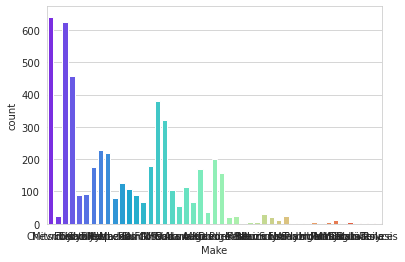

In [14]:
sns.set_style('whitegrid')
sns.countplot(x='Make', data=df, palette='rainbow')
sns.set(rc = {'figure.figsize':(15,10)})

In [15]:
df_cor = pd.concat([df, pd.get_dummies(df['Make'], prefix='Make')],axis=1)
df_cor

,Price,Year,Mileage,City,State,Vin,Make,Model,Current_Year,Age,Original_Price,Depreciation,Percent_Loss,Make_Acura,Make_Audi,Make_BMW,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_FIAT,Make_Ferrari,Make_Ford,Make_GMC,Make_Genesis,Make_HUMMER,Make_Honda,Make_Hyundai,Make_INFINITI,Make_Jaguar,Make_Jeep,Make_Kia,Make_Lamborghini,Make_Land,Make_Lexus,Make_Lincoln,Make_MINI,Make_Maserati,Make_Mazda,Make_Mercedes-Benz,Make_Mercury,Make_Mitsubishi,Make_Nissan,Make_Oldsmobile,Make_Plymouth,Make_Pontiac,Make_Porsche,Make_Ram,Make_Rolls-Royce,Make_Saab,Make_Saturn,Make_Scion,Make_Subaru,Make_Suzuki,Make_Tesla,Make_Toyota,Make_Volkswagen,Make_Volvo,Make_smart
0,24482,2014,37055,Matteson,IL,1GNKRJKDXEJ165034,Chevrolet,TraverseLTZ,2021,7,147149.511645,122667.511645,0.166375,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,26189,2017,25134,Grapevine,TX,1GAZGMFGXH1193321,Chevrolet,Express,2021,4,157409.466566,131220.466566,0.166375,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13208,2016,15682,ORLANDO,FL,JA32U2FU6GU000783,Mitsubishi,LancerES,2021,5,79386.927122,66178.927122,0.166375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7950,2006,96014,Midlothian,VA,1ZVFT80N065200235,Ford,Mustang2dr,2021,15,47783.621337,39833.621337,0.166375,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17900,2014,41081,Little Rock,AR,4T1BK1FK1EU027365,Toyota,CamryXLE,2021,7,107588.279489,89688.279489,0.166375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,17500,2014,51196,Langhorne,PA,5XYZUDLB2EG143081,Hyundai,Santa,2021,7,105184.072126,87684.072126,0.166375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4996,21464,2016,16852,Redford,MI,1FMCU9GXXGUB46610,Ford,Escape4WD,2021,5,129009.767092,107545.767092,0.166375,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4997,15201,2014,7504,Bethlehem,PA,1G1PC5SB5E7458741,Chevrolet,Cruze1LT,2021,7,91365.890308,76164.890308,0.166375,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,29984,2016,45404,Wendell,NC,1FM5K7F89GGC48766,Ford,ExplorerFWD,2021,5,180219.383922,150235.383922,0.166375,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


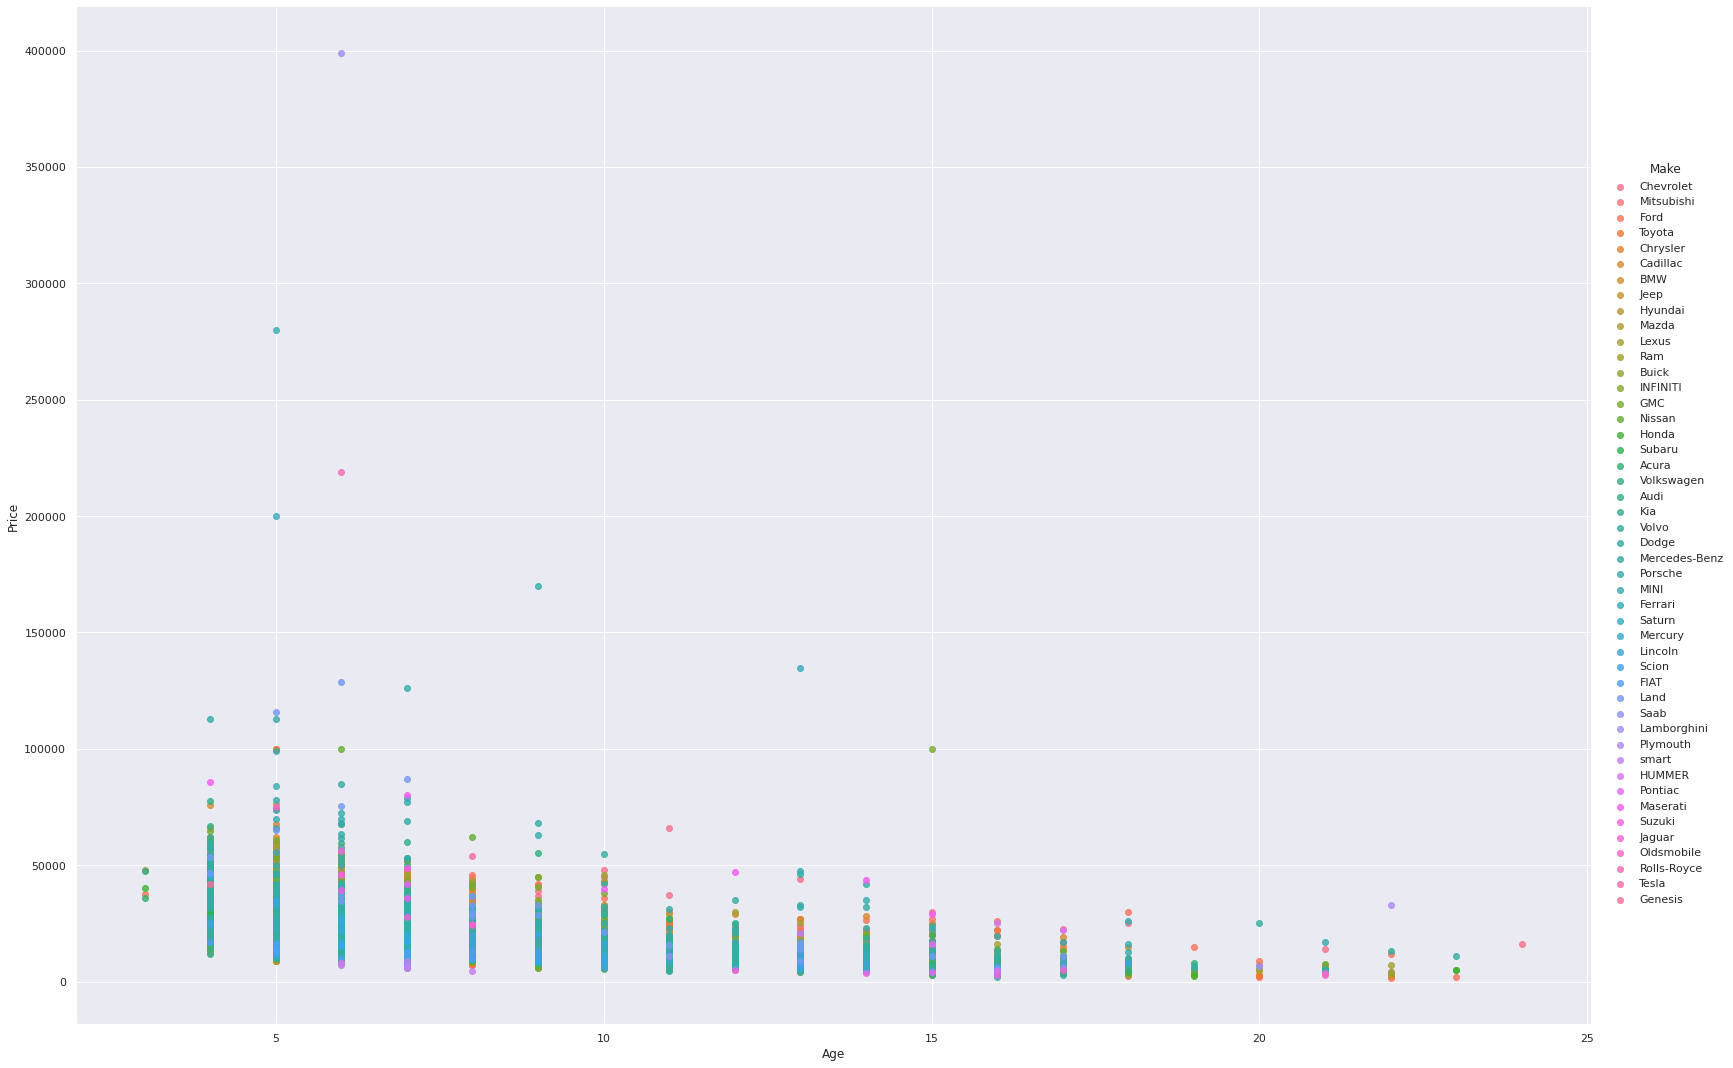

In [16]:
sns.lmplot(x='Age', y='Price', hue='Make', data= df_cor, fit_reg= False, height=15, aspect=1.5)

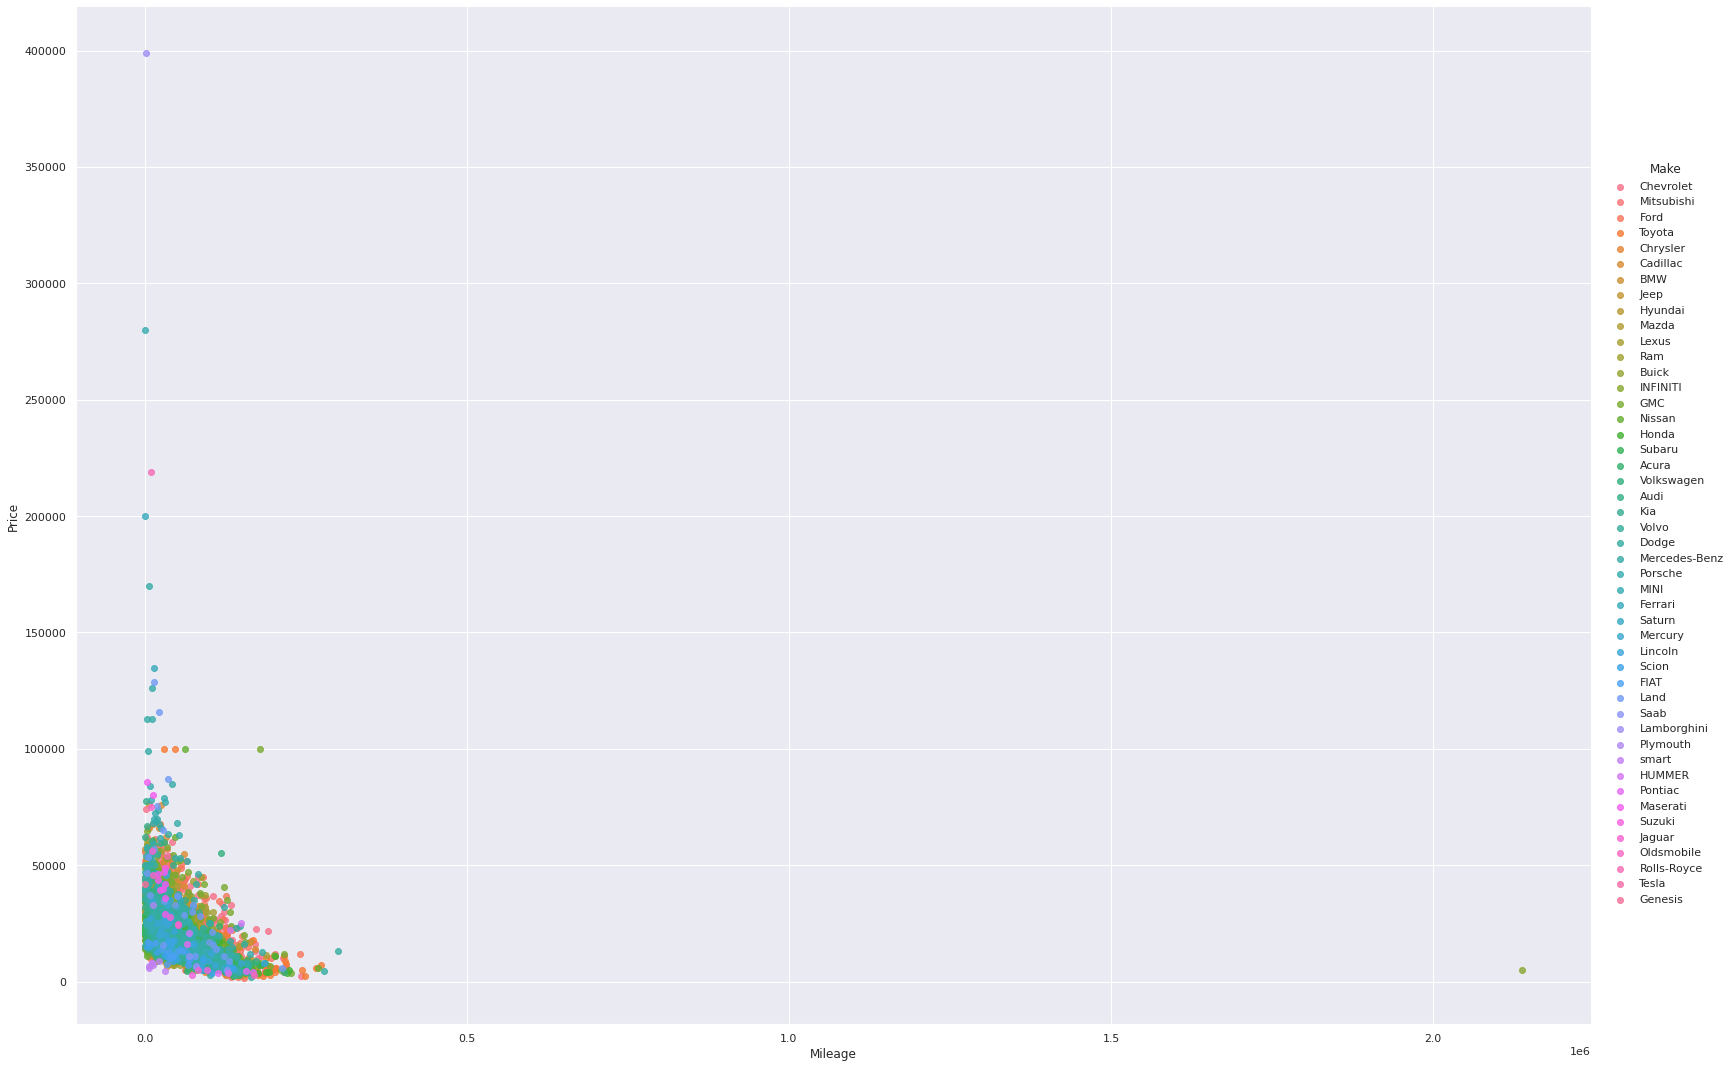

In [17]:
sns.lmplot(x='Mileage', y='Price', hue='Make', data= df_cor, fit_reg= False, height=15, aspect=1.5)

# **Gini Score for Feature Importance**

In [18]:
X = df.drop(['Price', 'Vin', 'Make', 'Model', 'Current_Year', "City", "State"], axis=1)
y = df['Price']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [20]:
et = ExtraTreesRegressor(n_estimators=100)
et.fit(X_train, y_train)

ExtraTreesRegressor()

In [21]:
et.feature_importances_

array([0.0057715 , 0.00291887, 0.00316893, 0.47755859, 0.51058211,
       0.        ])

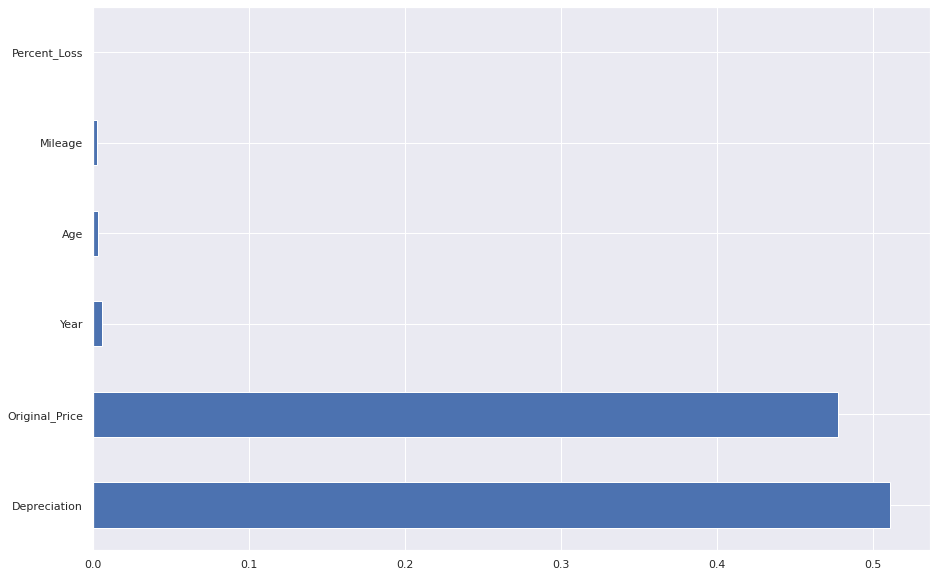

In [22]:
(pd.Series(et.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))

# **Running KMeans**

In [23]:
def doKMeans(df, iterations=50):
  try:
    df.drop('cluster', axis=1, inplace=True)
  except:
    next
  X = df.iloc[:,1:]

  S={}
  SSE = {}

  rb = RobustScaler()
  X_rb = rb.fit_transform(X)

  for k in range(2, iterations):
      kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
      kmeans.fit(X_rb)
      SSE[k] = kmeans.inertia_
      S[k] = silhouette_score(X_rb, kmeans.labels_, random_state=10)


  fig, axs = plt.subplots(2)
  fig.tight_layout()
  axs[0].plot(list(SSE.keys()), list(SSE.values()))
  axs[0].set_xlabel("Number of Clusters")
  axs[0].set_ylabel("SSE Within Cluster")
  axs[0].set_title("Within Cluster SSE After K-Means Clustering")
  axs[0].set_xticks([i for i in range(2, iterations)])

  axs[1].plot(list(S.keys()), list(S.values()))
  axs[1].set_xlabel('Number of clusters')
  axs[1].set_ylabel("Silhouette Score")
  axs[1].set_xticks([i for i in range(2, iterations)])

def applyKMeans(df, clusters=2):
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]

    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10)  
    kmeans.fit(X_rb) 
    score = silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score))
    print("sse withing cluster: " + str(sse_within_cluster))
        
    return df

In [24]:
cluster_col = ['Price', 'Age', 'Year', 'Mileage']
df_cluster = df_cor[cluster_col]

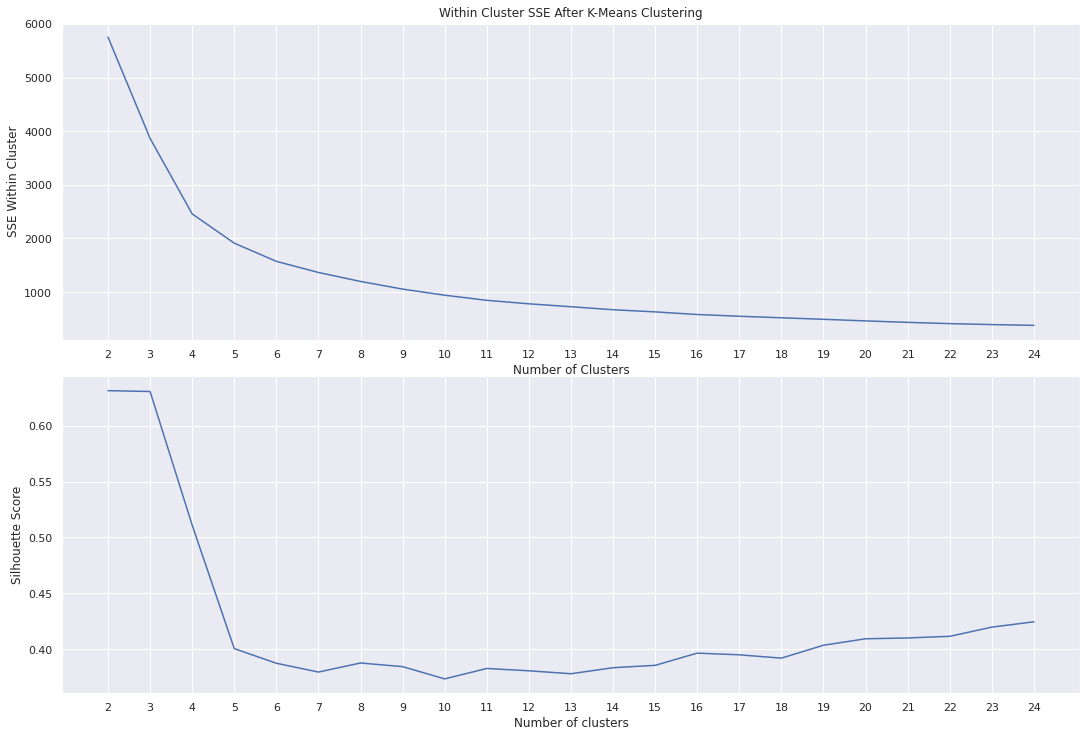

In [25]:
doKMeans(df_cluster, iterations=25)

In [26]:
first_trial = applyKMeans(df_cluster, clusters=8)

clustering performance
-----------------------------------
silhouette score: 0.38759764219488013
sse withing cluster: 1199.1268623519097


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"Price": "mean", "Age":"mean", "Mileage":"mean"})
    .sort_values('Price')
    .reset_index()
)
cluster_perf_df

,cluster,Price,Age,Mileage
0,2,4990.000000,16.000000,2.137327e+06
1,5,7297.893617,17.368794,1.714595e+05
2,1,11414.125000,12.100000,1.257315e+05
3,6,11586.631818,15.772727,9.392165e+04
4,4,16921.242574,11.029703,6.998229e+04
5,7,19000.043478,8.008696,7.235908e+04
6,0,23487.297775,6.591557,3.397527e+04
7,3,28012.278761,4.648968,1.937489e+04


# **Modeling**

In [28]:
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing
from sklearn import utils

In [29]:
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(2),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier()]

In [30]:
from datetime import datetime
import time

max_score = 0.0
max_class = ''
# iterate over classifiers
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
    
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

Classifier = Nearest Neighbors, Score (test, accuracy) = 3.52, Training time = 0.07 seconds
Classifier = Decision Tree, Score (test, accuracy) = 5.52, Training time = 0.21 seconds
Classifier = Random Forest, Score (test, accuracy) = 4.32, Training time = 0.47 seconds
Classifier = Neural Net, Score (test, accuracy) = 0.56, Training time = 154.35 seconds
Classifier = AdaBoost, Score (test, accuracy) = 1.20, Training time = 22.50 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 5.52


In [31]:
rf = RandomForestRegressor()

In [32]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [33]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [34]:
pred = rf.predict(X_test)
print(metrics.r2_score(y_test, pred))

0.9980105636135863


In [35]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
df1 = results.head(40)
df1.head(30)

,Actual,Predicted
4506,13939,13941.76
1273,27390,27371.15
357,41995,41983.02
478,29800,29788.90
356,22977,22977.96
3154,9450,9457.16
799,15200,15203.72
3762,19995,19994.99
3341,5999,5999.03
4282,10800,10801.26
